In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
    

# Define the data generators for training and validation 
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=30,
    horizontal_flip=True,
    fill_mode='nearest',
    shear_range=0.3,
    zoom_range=0.4
    )
    
val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'train/'
val_dir = 'valid/'

# create the training and validation data generators add data augmentation and repeat
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=160,
    class_mode='categorical',
    shuffle=True
    )

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=160,
    class_mode='categorical',
    shuffle=True
    )




ModuleNotFoundError: No module named 'tensorflow'

In [4]:
import tensorflow as tf
from tensorflow.keras import layers

# Create a base model using a pre-trained ResNet50V2 model
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
# add another layer
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(6, activation='softmax')(x)

# Create the final model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

model.fit(train_generator,
            epochs=100,
            validation_data=val_generator,
            verbose=1)
    



Epoch 1/100
35/35 [==============================] - 25s 632ms/step - loss: 2.2578 - accuracy: 0.2567 - val_loss: 1.3567 - val_accuracy: 0.4833
Epoch 2/100
35/35 [==============================] - 16s 457ms/step - loss: 1.8848 - accuracy: 0.3070 - val_loss: 1.2024 - val_accuracy: 0.5879
Epoch 3/100
35/35 [==============================] - 17s 489ms/step - loss: 1.6600 - accuracy: 0.3729 - val_loss: 1.1057 - val_accuracy: 0.6381
Epoch 4/100
35/35 [==============================] - 19s 543ms/step - loss: 1.4847 - accuracy: 0.4329 - val_loss: 1.0361 - val_accuracy: 0.6590
Epoch 5/100
35/35 [==============================] - 17s 495ms/step - loss: 1.4213 - accuracy: 0.4583 - val_loss: 0.9841 - val_accuracy: 0.6653
Epoch 6/100
35/35 [==============================] - 15s 427ms/step - loss: 1.3334 - accuracy: 0.4968 - val_loss: 0.9308 - val_accuracy: 0.6695
Epoch 7/100
35/35 [==============================] - 15s 435ms/step - loss: 1.2787 - accuracy: 0.5344 - val_loss: 0.9032 - val_accuracy:

KeyboardInterrupt: 

In [ ]:
# Save the model
model.save('trashnetRMSP.h5')

<Figure size 640x480 with 0 Axes>

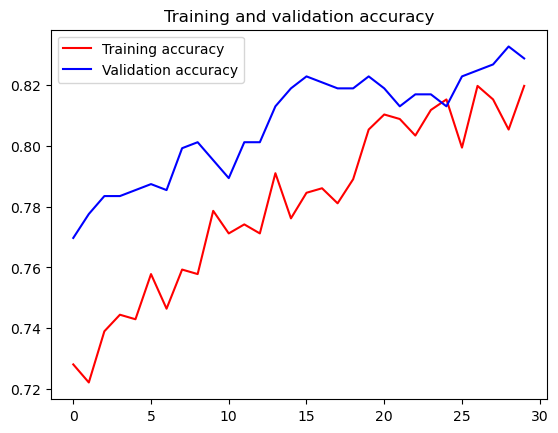

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot evaluation metrics
import matplotlib.pyplot as plt

acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

<Figure size 640x480 with 0 Axes>

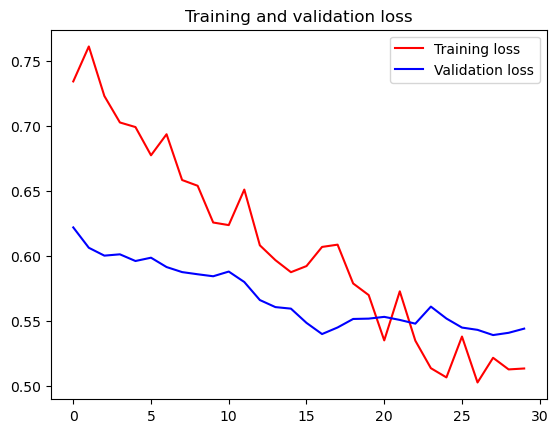

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


16/16 [==============================] - 5s 235ms/step
No of errors = 393/508


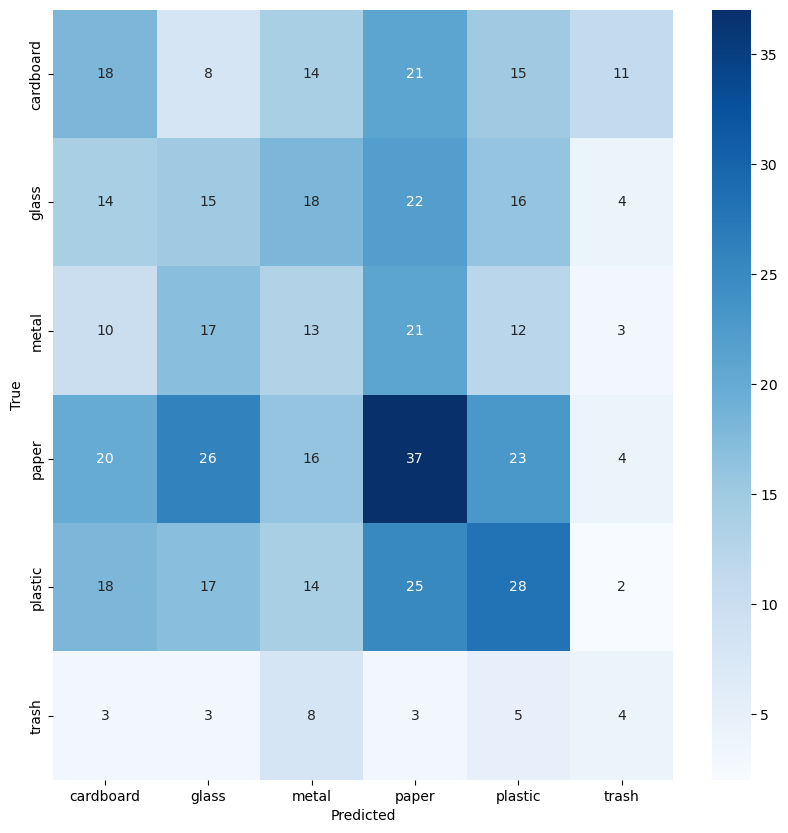

In [ ]:
# plot seaborn confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# get the labels of the test images.
test_labels = val_generator.classes

# make a prediction
predictions = model.predict(val_generator)

# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

errors = np.where(predicted_classes != test_labels)[0]
print("No of errors = {}/{}".format(len(errors),val_generator.samples))

cm = confusion_matrix(test_labels, predicted_classes)
cm_plot_labels = ['cardboard','glass','metal','paper','plastic','trash']

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

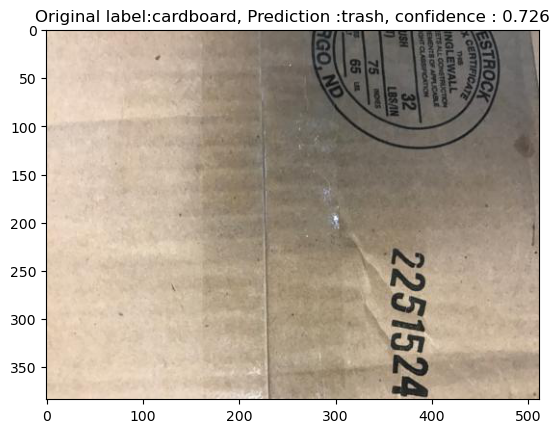

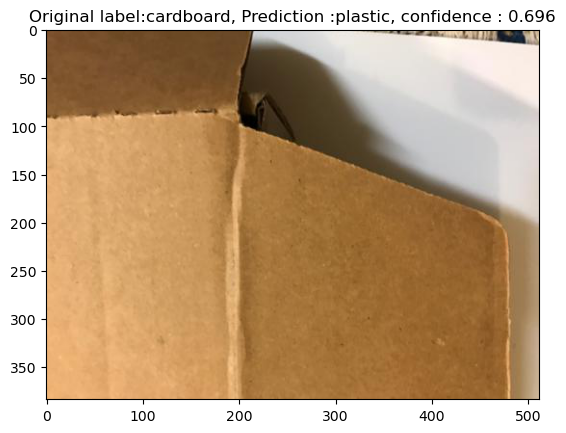

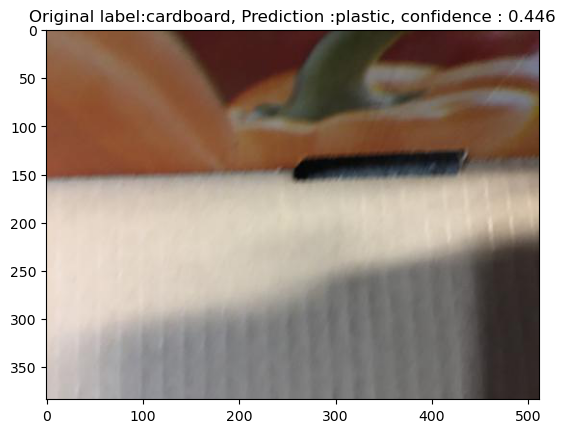

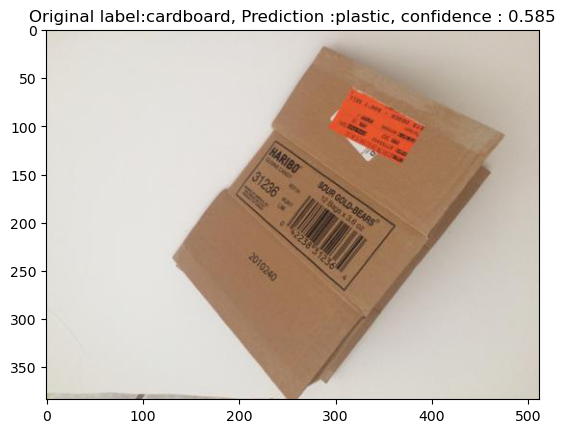

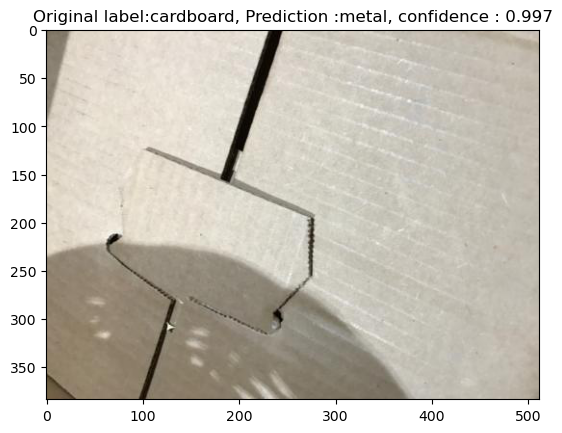

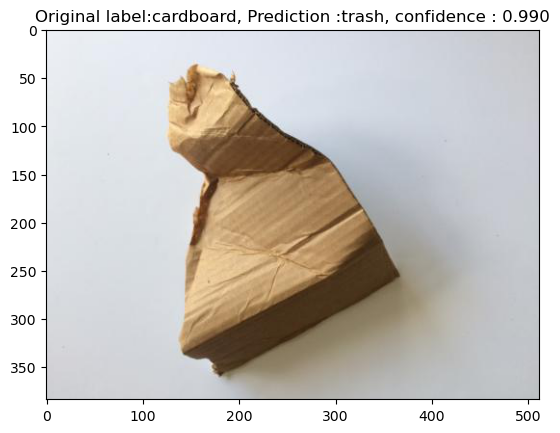

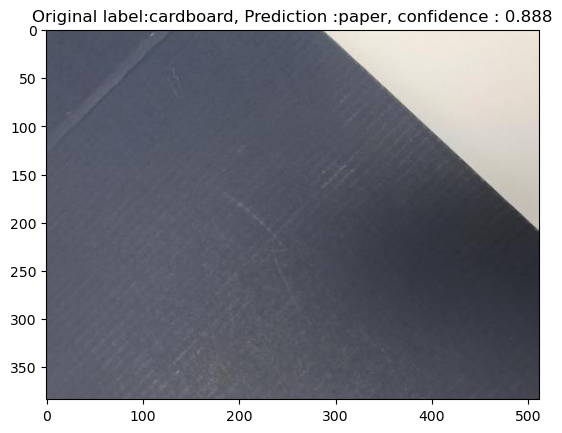

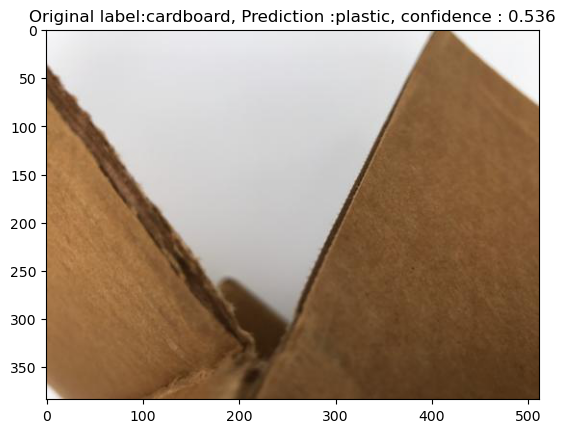

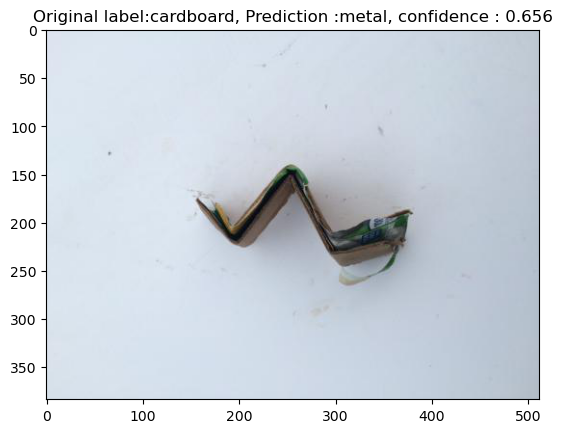

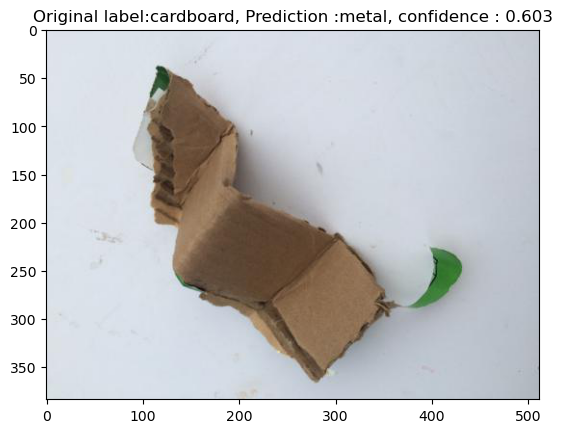

In [ ]:
load_img = tf.keras.preprocessing.image.load_img

# show some misclassified examples
for i in range(len(errors)):
    ax, fig = plt.subplots(1,1)
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = cm_plot_labels[pred_class]

    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        cm_plot_labels[test_labels[errors[i]]], pred_label, predictions[errors[i]][pred_class])

    original = load_img('{}/{}'.format(val_dir, val_generator.filenames[errors[i]]))
    plt.imshow(original)
    plt.title(title)
    plt.show()
    if i == 9:
        break
